In [0]:
import os
import time
import re
import warnings
import copy
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
warnings.filterwarnings('ignore')

In [0]:
def seed_everything(seed):
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)

seed_everything(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [5]:
# DOWNLOAD DATASETS
!wget https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip
!wget https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_sDO3m7O.csv

!unzip -q train_DETg9GD.zip
!unzip -q test_Bh8pGW3.zip 

!rm test_Bh8pGW3.zip
!rm train_DETg9GD.zip

--2020-05-23 17:19:20--  https://datahack-prod.s3.amazonaws.com/train_zip/train_DETg9GD.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.112
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50160162 (48M) [application/zip]
Saving to: ‘train_DETg9GD.zip’

train_DETg9GD.zip   100%[===================>]  47.84M  17.9MB/s    in 2.7s    

2020-05-23 17:19:24 (17.9 MB/s) - ‘train_DETg9GD.zip’ saved [50160162/50160162]

--2020-05-23 17:19:26--  https://datahack-prod.s3.amazonaws.com/test_zip/test_Bh8pGW3.zip
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.60
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17007053 (16M) [application/zip]
Saving to: ‘test_Bh8pGW3.zip’

test_Bh8pGW3.zi

In [6]:
# LOADING DATASET
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission_sDO3m7O.csv')
col_class = sample['Class']
col_class = pd.DataFrame(col_class, columns=['Class'])
test = pd.concat([test, col_class], axis=1)
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [7]:
traincpy = train.copy()
traincpy = pd.get_dummies(traincpy, columns=['Class'], prefix='Class')
traincpy.head()

,ID,Class_MIDDLE,Class_OLD,Class_YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [8]:
classes = np.unique(train['Class'])
num_classes = len(classes)
print(classes)
print(num_classes)

['MIDDLE' 'OLD' 'YOUNG']
3


In [0]:
def showimg(img, unnormalize=True):
  if unnormalize:
    img = img * 0.5 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

def plot_loss(train, val):
  x = np.arange(1, len(train)+1)
  plt.figure(figsize=(10,6))
  plt.plot(x, train, label='Training Loss')
  plt.plot(x, val, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses!')
  plt.legend(loc='upper right')
  plt.show()

In [0]:
# MAKING DATALOADER
class load_data(Dataset):
  def __init__(self, df, root, phase):
    self.df = df
    self.dir = root
    if phase == 'train':
      self.transforms = A.Compose([A.Resize(256,256), A.RandomCrop(244,244), A.Flip(),
                                   A.RGBShift(), A.Rotate(30), A.Blur(5), A.GaussNoise(), A.RandomBrightnessContrast(),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])
    else:
      self.transforms = A.Compose([A.Resize(256,256), A.RandomCrop(244,244), A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ToTensor()])

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df['ID'].iloc[idx]
    img_path = os.path.join(self.dir, str(img_id))
    labels = self.df.iloc[idx, 1:].to_numpy()
    labels = np.argmax(labels)
    img = plt.imread(img_path)
    img = self.transforms(image=np.array(img))['image']
    return img, labels

In [0]:
batch_size = 128

In [0]:
#DEFINING DATALOADER
train, val = train_test_split(traincpy, test_size = 0.3)
trainset = load_data(train, 'Train', 'train')
valset = load_data(val, 'Train', 'eval')
testset = load_data(test, 'Test', 'eval')
tdl = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
vdl = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
testdl = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    MIDDLE      YOUNG     MIDDLE     MIDDLE


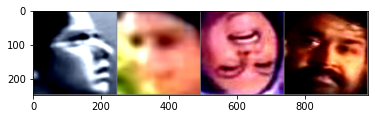

In [35]:
# SHOWING IMAGES (ONLY 4 FOR BREVITY)
images, label = next(iter(tdl))
showimg(torchvision.utils.make_grid(images))
print(' '.join('{:>10}'.format(classes[label[j]]) for j in range(batch_size)))

In [0]:
#DEFINING TRAINER
def train_it(model, dataloader, criterion, optimizer, scheduler, epochs, verbose=False, print_every=25):
  since = time.time()
  train_history = []
  val_history = []
  model.train()
  best_model = model.state_dict()
  train_ldr = dataloader['train']
  val_ldr = dataloader['val']
  for epoch in range(1, epochs+1):
    print('Epoch: {} of {}'.format(epoch, epochs))
    start = time.time()
    total_train_loss = 0.0
    running_acc = 0.0
    for i, (img, labels) in enumerate(dataloader['train']):
      img, labels = img.to(device), labels.to(device)
      optimizer.zero_grad()

      score = model(img)
      loss = criterion(score, labels)
      loss.backward()
      optimizer.step()
      _, pred = torch.max(score, dim=1)
      running_acc += torch.sum(pred==labels.data)
      
      total_train_loss += loss.item()*img.size(0)

      if (i) % (print_every) == 0 and verbose:    
                print("Completed {:d}% of 100%".format(int(100 * (i) / len(dataloader['train']))))

    epoch_train_acc = running_acc.double() / len(dataloader['train'].dataset)
    timer = time.time() - start
    print('Train Loss: {:.4f} \t Train accuracy: {:.4f} \t took {}m {}s'.format(total_train_loss / len(dataloader['train'].dataset),
                                                             epoch_train_acc.item(), timer/60, timer%60))
    train_history.append(total_train_loss / len(dataloader['train'].dataset))

    # EVALUATING NOW...

    model.eval()
    total_val_loss = 0.0
    best_loss = np.inf
    running_val_acc = 0.0
    with torch.no_grad():
      for (img, labels) in dataloader['val']:
        img, labels = img.to(device), labels.to(device)
        val_score = model(img)
        val_loss = criterion(val_score, labels)
        total_val_loss += val_loss.item() * img.size(0)
        _, vpred = torch.max(val_score, dim=1)
        running_val_acc += torch.sum(vpred==labels.data)
      
    epoch_val_loss = total_val_loss / len(dataloader['val'].dataset)
    val_history.append(epoch_val_loss)
    val_acc = running_val_acc / len(dataloader['val'].dataset)
    state = {'epoch':epoch, 'best_loss':best_loss,
             'state':model.state_dict(), 'optimizer':optimizer.state_dict(),
             'scheduler':scheduler.state_dict()}
    if scheduler:
      scheduler.step(epoch_val_loss)
    if epoch_val_loss < best_loss:
      state['best_loss'] = best_loss = epoch_val_loss
      torch.save(state, 'model.pth')
      best_model = model.state_dict()
    
    print("Validation loss = {:.4f} \t Validation accuracy = {}".format(epoch_val_loss, val_acc))
    print('```````````````````````````````````````````````````````````')
  timer = time.time() - since)
  print("Training Finished, took {}m {}s".format(timer/60, timer%60))

  #model.load_state_dict(torch.load('model.pth')
  return best_model, train_history, val_history

In [74]:
best_model, train_hist, val_hist = train_it(model,  dataldr, criterion, optimizer, scheduler, 5, verbose=True)

Epoch: 1 of 5
Completed 0% of 100%
Completed 22% of 100%
Completed 45% of 100%
Completed 68% of 100%
Completed 91% of 100%
Train Loss: 0.9106 	 Train accuracy: 0.6307 	 took 100.09s
Validation loss = 0.8889 	 Validation accuracy = 0.6552243828773499
```````````````````````````````````````````````````````````
Epoch: 2 of 5
Completed 0% of 100%
Completed 22% of 100%
Completed 45% of 100%
Completed 68% of 100%
Completed 91% of 100%
Train Loss: 0.9014 	 Train accuracy: 0.6399 	 took 98.94s
Validation loss = 0.8827 	 Validation accuracy = 0.6615874171257019
```````````````````````````````````````````````````````````
Epoch: 3 of 5
Completed 0% of 100%
Completed 22% of 100%
Completed 45% of 100%
Completed 68% of 100%
Completed 91% of 100%
Train Loss: 0.8966 	 Train accuracy: 0.6448 	 took 98.15s
Validation loss = 0.8788 	 Validation accuracy = 0.663931667804718
```````````````````````````````````````````````````````````
Epoch: 4 of 5
Completed 0% of 100%
Completed 22% of 100%
Completed 45% of

In [0]:
def test_it(model, testldr, verbose=False):
  model.eval()
  final_pred = []
  with torch.no_grad():
    for (img, label) in testldr:
      img, label = img.to(device), label.to(device)
      output = model(img)
      _, pred = torch.max(output, dim=1)
      final_pred.append(pred.cpu().numpy().data)
    if verbose:
      print('Done evaluating, finishing up...')
    final_pred = np.concatenate(final_pred)
    testcopy['Class'] = final_pred
  return testcopy

In [16]:
# DEFINING MODEL
model = models.resnet50(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model_classes = model.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
model.fc = nn.Sequential(nn.Linear(model_classes, num_classes*4), nn.Dropout(0.2), nn.ReLU(), nn.Linear(num_classes*4, num_classes), nn.Softmax())
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=2e-3, betas=(0.9, 0.999),weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', threshold=0.01 patience=3)
dataldr = {'train': tdl, 'val':vdl}

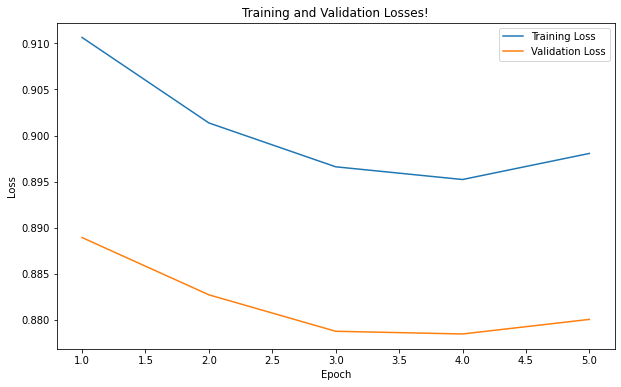

In [75]:
# PLOTTING LOSSES
plot_loss(train_hist, val_hist)

In [79]:
testcopy = test.copy()
prediction = test_it(model, testdl, verbose=True)
prediction.head()

Done evaluating, finishing up...


,ID,Class
0,25321.jpg,2
1,989.jpg,2
2,19277.jpg,0
3,13093.jpg,0
4,5367.jpg,0


In [0]:
mapper = {'Class':{0:'MIDDLE', 1:'OLD', 2:'YOUNG'}}
prediction.replace(mapper, inplace=True)
new_col = ['Class', 'ID']
prediction = prediction.reindex(columns=new_col)
prediction.head()

In [0]:
prediction.to_csv('submission.csv', index=False)